In [39]:
#Ok so we want to train a model that uses the cell probabilities from our cp unet to predict cell masks

import matplotlib.pyplot as plt


In [314]:
#First step is importing the images and masks
import tifffile
import numpy as np
from os import listdir
from os.path import isfile, join
#from the data_for_cellpose folder import the images and masks
#get all the names 
images_path = 'data_for_cellpose'
onlyfiles = [f for f in listdir(images_path) if isfile(join(images_path, f))] #not ordered in the right way
images = []
masks = []
for i in range(len(onlyfiles)):
    if onlyfiles[i].endswith('.tiff'):
        #impor tthe tiffile into the images folder
        images.append(np.squeeze(tifffile.imread(images_path + '\\' + onlyfiles[i])))
    elif onlyfiles[i].endswith('.npy'):
        #import the npy file into the masks folder
        masks.append(np.squeeze(np.load(images_path + '\\' +  onlyfiles[i], allow_pickle=True).item()['masks']))

images = [(image-np.min(image))/(np.max(image)-np.min(image)) for image in images]

In [199]:
#binarise the masks
masks = [mask.astype(int) for mask in masks]
masks = np.where(np.array(masks) > 0, 1, 0)
print(np.unique(masks))

[0 1]


In [316]:
print(masks[0].shape)

(1080, 1080)


In [200]:
#Second step is to import the cell probabilities model into a U-net
import torch
from u_net import UNet
cp_model = UNet()
cp_model.load_state_dict(torch.load('saved_weights\cell-probability-map-U-Net-best.pt',map_location=torch.device('cuda:0')))

<All keys matched successfully>

In [201]:
#pad the images in the array images by 100 piels on each side
images_padded = []
for i in range(len(images)):
    images_padded.append(np.pad(images[i],100,'constant',constant_values=0))
#split the images into arrays of 128x128
images_split = []
for i in range(len(images_padded)):
    images_split.append(np.array_split(images_padded[i],1280/128,axis=0))
for i in range(len(images_split)):
    for j in range(len(images_split[i])):
        images_split[i][j] = np.array_split(images_split[i][j],1280/128,axis=1)
#put all of these images into a single array
images_split = np.array(images_split)
#reshape array to be 2400x128x128
images_split = images_split.reshape(24,100,128,128)

In [202]:
#Third step is to get the cellprobabilities from the cp unet
#put the images into a tensor
images_tensor = torch.from_numpy(images_split).float()
#put the tensor into the cp unet
cp_model.eval()
cp_model.cuda()
cellprobabilities = []
for i in range(len(images_tensor)):
    data = torch.squeeze(images_tensor[i])
    data = torch.unsqueeze(data,1)
    pred = cp_model(data.cuda())
    cellprobabilities.append(pred[1].cpu().detach().numpy())
#now we have the cell probabilities
cellprobabilities_final = []
for cellprob in cellprobabilities:
    #loop through cellprobabiliites and for each image put the 128x128 crops back together
    full_image = np.zeros((1280, 1280))

    # Loop over each of the 100 128 by 128 numpy arrays and copy them into the larger image
    for i in range(10):
        for j in range(10):
            full_image[i*128:(i+1)*128, j*128:(j+1)*128] = cellprob[i*10+j]
    full_image = full_image[100:-100, 100:-100]
    cellprobabilities_final.append(full_image)

In [203]:
#Fourth step is to separate that data into training and testing with the masks
#split the data into training and testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(cellprobabilities_final, masks, test_size=0.2, random_state=42)

def split_images(images):
    images_padded = []
    for i in range(len(images)):
        images_padded.append(np.pad(images[i],100,'constant',constant_values=0))
    #split the images into arrays of 128x128
    images_split = []
    for i in range(len(images_padded)):
        images_split.append(np.array_split(images_padded[i],1280/128,axis=0))
    for i in range(len(images_split)):
        for j in range(len(images_split[i])):
            images_split[i][j] = np.array_split(images_split[i][j],1280/128,axis=1)
    #put all of these images into a single array
    
    images_split = np.array(images_split)
    images_split = images_split.reshape(images_split.shape[0]*100,128,128)
    return images_split

def combine_images(images):
    images_combined = []
    for image in images:
        #loop through cellprobabiliites and for each image put the 128x128 crops back together
        full_image = np.zeros((1280, 1280))

        # Loop over each of the 100 128 by 128 numpy arrays and copy them into the larger image
        for i in range(10):
            for j in range(10):
                full_image[i*128:(i+1)*128, j*128:(j+1)*128] = image[i*10+j]
        full_image = full_image[100:-100, 100:-100]
        images_combined.append(full_image)
    return images_combined

X_train_split = split_images(X_train)
X_test_split = split_images(X_test)
y_train_split = split_images(y_train)
y_test_split = split_images(y_test)

In [309]:
images_train, images_test, y_train, y_test = train_test_split(images, images, test_size=0.2, random_state=42)
images_train_split = split_images(images_train)
images_test_split = split_images(images_test)

In [204]:
#for each image in X_train, rotate by 90, 180, 270 degrees and add to X_train
#also rotate the corresponding y_train image by the same amount
X_train_split = X_train_split.tolist()
y_train_split = y_train_split.tolist()
for i in range(len(X_train_split)):
    if i % 100 == 0:
        print(i)
    X_train_split.append(np.rot90(X_train_split[i],1))
    X_train_split.append(np.rot90(X_train_split[i],2))
    X_train_split.append(np.rot90(X_train_split[i],3))
    y_train_split.append(np.rot90(y_train_split[i],1))
    y_train_split.append(np.rot90(y_train_split[i],2))
    y_train_split.append(np.rot90(y_train_split[i],3))

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800


In [205]:
#make data loaders
from torch.utils.data import TensorDataset, DataLoader
X_train_split = np.array(X_train_split)
y_train_split = np.array(y_train_split)
train_data = TensorDataset(torch.from_numpy(X_train_split.astype('float16')), torch.from_numpy(y_train_split.astype('float16')))
test_data = TensorDataset(torch.from_numpy(X_test_split.astype('float16')).float(), torch.from_numpy(y_test_split.astype('float16')).float())


In [206]:
import torch.nn as nn
import torch.nn.functional as F
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        #inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss
        
        return Dice_BCE

In [207]:
#Then we train a new U-Net using the best cellmask model hyperaparmeters
cellmask_model = UNet()
cellmask_model.cuda()
#set the hyperparameters
from torch.utils.data import DataLoader
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)
criterion = DiceBCELoss()
optimizer = torch.optim.RMSprop(cellmask_model.parameters(), lr=0.001)

#train the model
epochs = 10
for epoch in range(epochs):
    cellmask_model.train()
    train_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.float(), target.float()
        data, target = data.cuda(), target.cuda()
        data = torch.unsqueeze(data,1)
        target = torch.unsqueeze(target,1)
        optimizer.zero_grad()
        output = cellmask_model(data)[1]
        output = F.sigmoid(output)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print('Train set: Average loss: {:.4f}'.format(train_loss / len(train_loader.dataset)))

    cellmask_model.eval()
    test_loss = 0.0
    for batch_idx, (data, target) in enumerate(test_loader):
        data, target = data.float(), target.float()
        data, target = data.cuda(), target.cuda()
        data = torch.unsqueeze(data,1)
        target = torch.unsqueeze(target,1)
        output = cellmask_model(data)[1]
        output = F.sigmoid(output)
        loss = criterion(output, target)
        test_loss += loss.item()
    print('Test set: Average loss: {:.4f}'.format(test_loss / len(test_loader.dataset)))

c:\Users\rz200\AppData\Local\anaconda3\envs\cellprob\lib\site-packages\torch\nn\functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train set: Average loss: 0.0156
Test set: Average loss: 0.0193
Train set: Average loss: 0.0127
Test set: Average loss: 0.0190
Train set: Average loss: 0.0116
Test set: Average loss: 0.0195
Train set: Average loss: 0.0109
Test set: Average loss: 0.0195
Train set: Average loss: 0.0107
Test set: Average loss: 0.0187
Train set: Average loss: 0.0106
Test set: Average loss: 0.0179
Train set: Average loss: 0.0104
Test set: Average loss: 0.0194
Train set: Average loss: 0.0103
Test set: Average loss: 0.0178
Train set: Average loss: 0.0101
Test set: Average loss: 0.0183
Train set: Average loss: 0.0100
Test set: Average loss: 0.0184


In [280]:
#let's get the cellpose data and train a model on that
import cellpose
from cellpose import models, io ,utils

cellpose_model = models.Cellpose(gpu=True, model_type='nuclei')
cellpose_probs = []
for i in range(len(X_train_split)):
    if i % 100 == 0:
        print(i)
    masks, flows, styles, diams = cellpose_model.eval(X_train_split[i])
    cellpose_probs.append(flows[2])

0
100
200
300
400
500
600


700
800


900
1000
1100
1200
1300
1400
1500
1600
1700


1800
1900
2000
2100
2200


2300
2400
2500
2600
2700
2800
2900
3000


3100
3200
3300


3400
3500
3600
3700
3800


3900
4000
4100
4200
4300
4400


4500
4600
4700
4800
4900


5000
5100


5200
5300
5400
5500


5600
5700


5800
5900
6000
6100
6200


6300
6400


6500
6600
6700
6800
6900


7000


7100
7200
7300


7400
7500


In [282]:
cellpose_model = models.Cellpose(gpu=True, model_type='nuclei')
cellpose_probs_test = []
for i in range(len(X_test_split)):
    if i % 100 == 0:
        print(i)
    masks, flows, styles, diams = cellpose_model.eval(X_test_split[i])
    cellpose_probs_test.append(flows[2])

0
100
200
300


400


In [283]:
X_train_split_cellprobs = cellpose_probs
X_test_split_cellprovs = cellpose_probs_test

In [284]:
#make data loaders
from torch.utils.data import TensorDataset, DataLoader
X_train_split_cellprobs = np.array(X_train_split_cellprobs)
y_train_split = np.array(y_train_split)
X_test_split_cellprobs = np.array(X_test_split_cellprovs)
y_test_split = np.array(y_test_split)

train_data_cellprobs = TensorDataset(torch.from_numpy(X_train_split_cellprobs.astype('float16')), torch.from_numpy(y_train_split.astype('float16')))
test_data_cellprobs = TensorDataset(torch.from_numpy(X_test_split_cellprobs.astype('float16')).float(), torch.from_numpy(y_test_split.astype('float16')).float())


In [311]:
#TRAINING MASK MODEL WITH CELLPOSE CELLPROBS
#Then we train a new U-Net using the best cellmask model hyperaparmeters
cellpose_cellprob_model = UNet()
cellpose_cellprob_model.cuda()
#set the hyperparameters
from torch.utils.data import DataLoader
train_loader = DataLoader(train_data_cellprobs, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data_cellprobs, batch_size=32, shuffle=True)
criterion = DiceBCELoss()
optimizer = torch.optim.RMSprop(cellpose_cellprob_model.parameters(), lr=0.001)

#train the model
epochs = 30
for epoch in range(epochs):
    cellpose_cellprob_model.train()
    train_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.float(), target.float()
        data, target = data.cuda(), target.cuda()
        data = torch.unsqueeze(data,1)
        target = torch.unsqueeze(target,1)
        optimizer.zero_grad()
        output = cellpose_cellprob_model(data)[1]
        output = F.sigmoid(output)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print('Train set: Average loss: {:.4f}'.format(train_loss / len(train_loader.dataset)))

    cellpose_cellprob_model.eval()
    test_loss = 0.0
    for batch_idx, (data, target) in enumerate(test_loader):
        data, target = data.float(), target.float()
        data, target = data.cuda(), target.cuda()
        data = torch.unsqueeze(data,1)
        target = torch.unsqueeze(target,1)
        output = cellpose_cellprob_model(data)[1]
        output = F.sigmoid(output)
        loss = criterion(output, target)
        test_loss += loss.item()
    print('Test set: Average loss: {:.4f}'.format(test_loss / len(test_loader.dataset)))

Train set: Average loss: 0.0235
Test set: Average loss: 0.0266
Train set: Average loss: 0.0169
Test set: Average loss: 0.0223
Train set: Average loss: 0.0154
Test set: Average loss: 0.0208
Train set: Average loss: 0.0148
Test set: Average loss: 0.0208
Train set: Average loss: 0.0142
Test set: Average loss: 0.0197
Train set: Average loss: 0.0138
Test set: Average loss: 0.0198
Train set: Average loss: 0.0135
Test set: Average loss: 0.0199
Train set: Average loss: 0.0133
Test set: Average loss: 0.0192
Train set: Average loss: 0.0131
Test set: Average loss: 0.0198
Train set: Average loss: 0.0130
Test set: Average loss: 0.0190
Train set: Average loss: 0.0129
Test set: Average loss: 0.0209
Train set: Average loss: 0.0127
Test set: Average loss: 0.0195
Train set: Average loss: 0.0126
Test set: Average loss: 0.0203
Train set: Average loss: 0.0125
Test set: Average loss: 0.0191
Train set: Average loss: 0.0124
Test set: Average loss: 0.0207
Train set: Average loss: 0.0123
Test set: Average loss:

In [227]:
#calculate the dice loss on the test set
cellmask_model.eval()
dice_loss_total = 0
for batch_idx, (data, target) in enumerate(test_loader):
    data, target = data.float(), target.float()
    data, target = data.cuda(), target.cuda()
    data = torch.unsqueeze(data,1)
    target = torch.unsqueeze(target,1)
    output = cellmask_model(data)[1]
    output = F.sigmoid(output)

    #binarise the output
    output[output > 0.5] = 1
    output[output <= 0.5] = 0

    #calculate the dice coefficient
    intersection = (output * target).sum()
    dice_loss = 1 - (2.*intersection + 1)/(output.sum() + target.sum() + 1)
    dice_loss_total += dice_loss.item()
    
print(dice_loss_total/16)

c:\Users\rz200\AppData\Local\anaconda3\envs\cellprob\lib\site-packages\torch\nn\functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0.41374528780579567


In [287]:
#Now gettting predictions from the cellmask model trained on the cellpose predictions

cellmask_cellpose = UNet()
cellmask_cellpose.load_state_dict(torch.load('saved_weights\cell-mask-U-Net-best.pt',map_location=torch.device('cuda:0')))
cellmask_cellpose.cuda()

#calculate the dice loss on the test set
cellmask_cellpose.eval()
dice_loss_total = 0
for batch_idx, (data, target) in enumerate(test_loader):
    data, target = data.float(), target.float()
    data, target = data.to('cuda:0'), target.to('cuda:0')
    data = torch.unsqueeze(data,1)
    target = torch.unsqueeze(target,1)
    output = cellmask_cellpose(data)[1]
    output = F.sigmoid(output)

    #binarise the output
    output[output > 0.5] = 1
    output[output <= 0.5] = 0

    #calculate the dice coefficient
    intersection = (output * target).sum()
    dice_loss = 1 - (2.*intersection + 1)/(output.sum() + target.sum() + 1)
    dice_loss_total += dice_loss.item()
    
print(dice_loss_total/16)

0.6225946918129921


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.9975609756097561


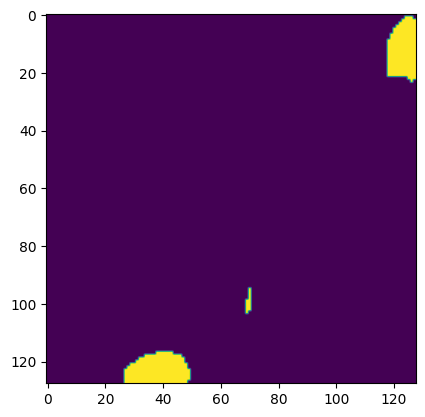

0.0
0.0
0.0
0.98989898989899


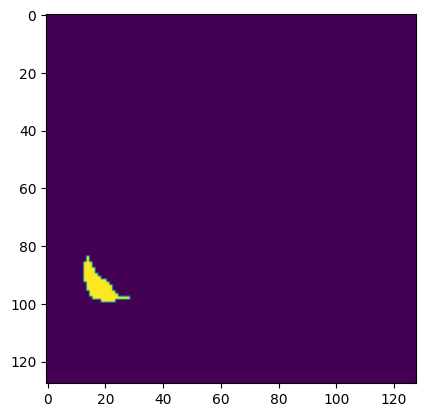

0.0
0.9947089947089947


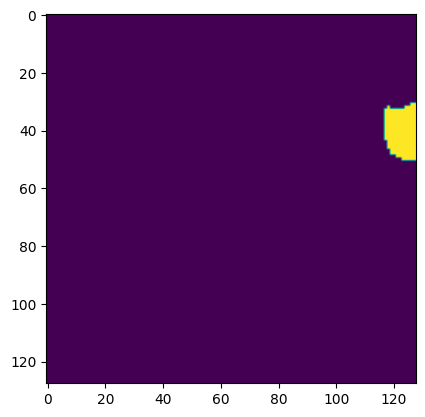

0.0
0.0
0.0
0.0
0.9945945945945946


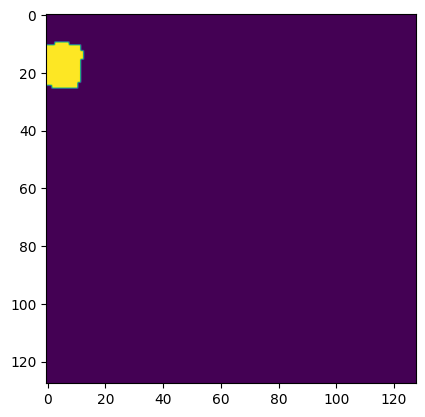

0.0
0.0
0.0
0.0
0.0
0.0
0.9966329966329966


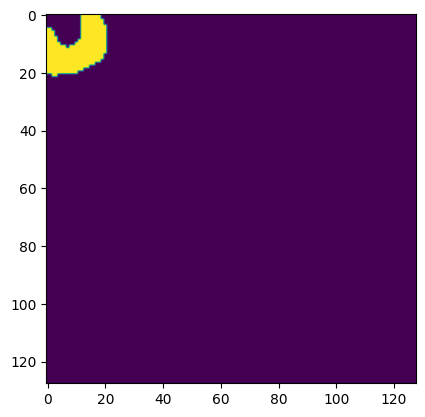

0.0
0.9836065573770492


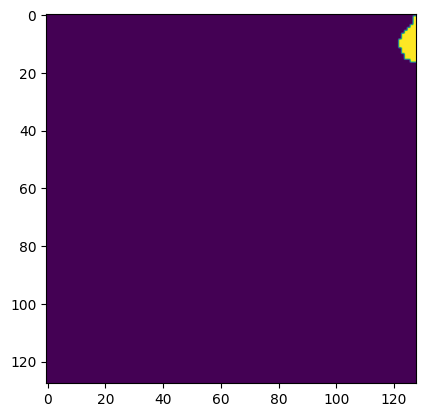

0.9980392156862745


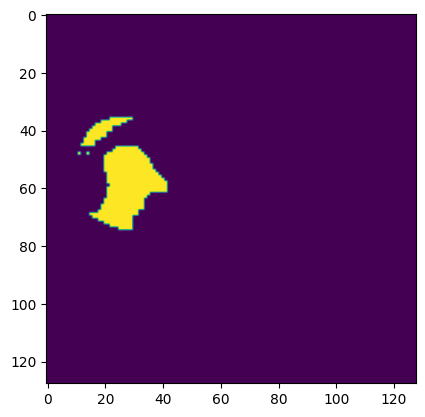

0.0
0.9963369963369964


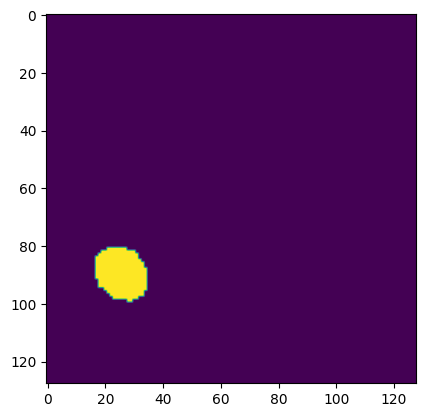

0.998587570621469


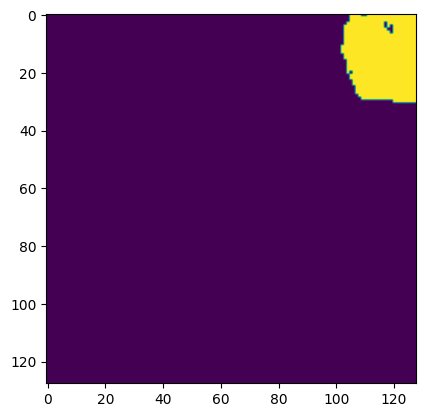

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.9923076923076923


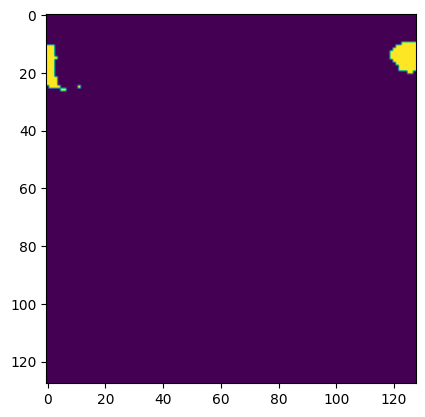

0.9941520467836258


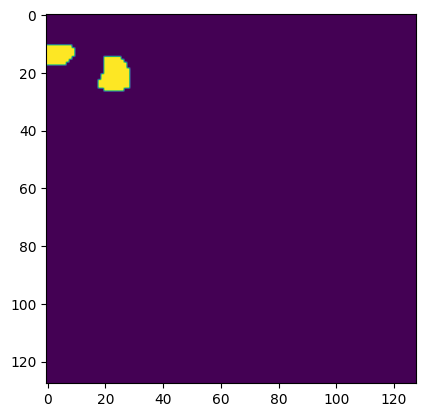

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.9444444444444444


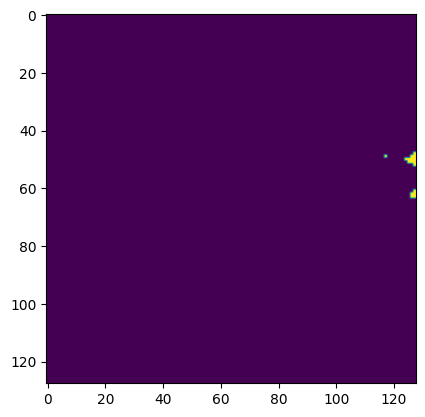

0.0
0.0
0.9943181818181818


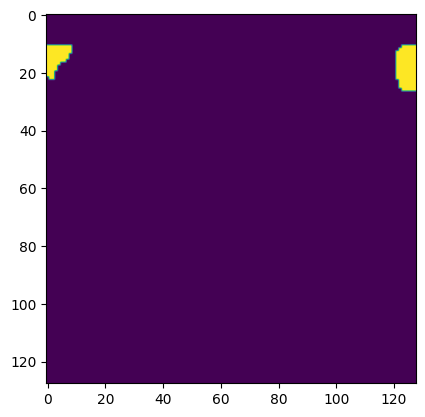

0.0
0.9935483870967742


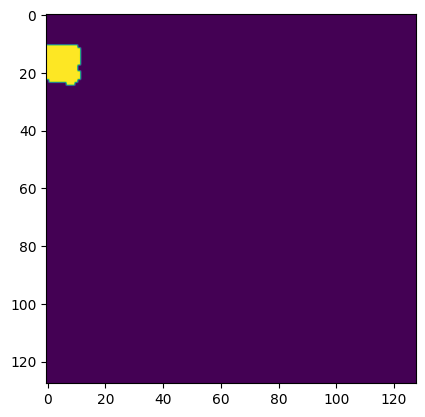

0.98


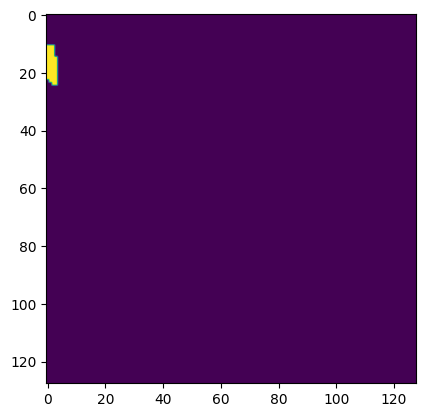

0.9974489795918368


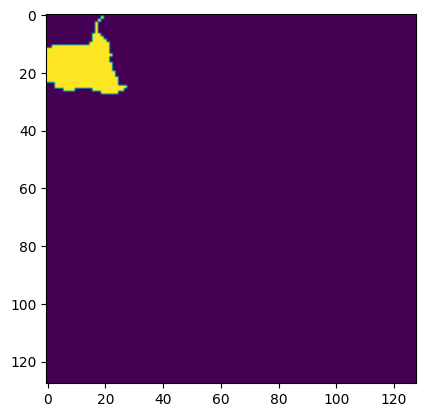

0.0
0.0
0.0
0.0
0.0
0.9696969696969697


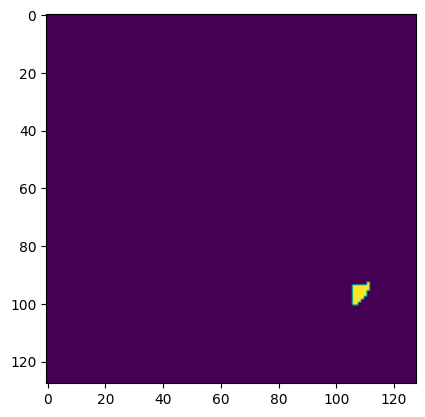

0.0
0.9875


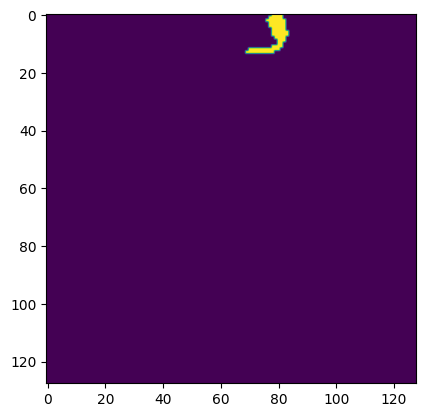

0.0
0.9827586206896551


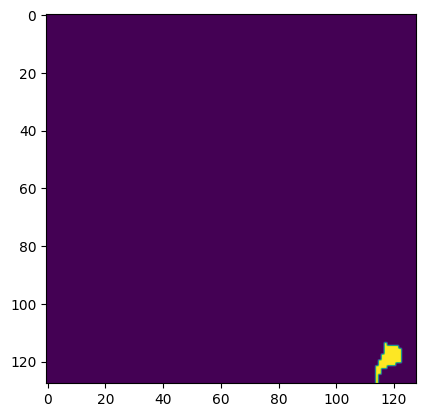

0.0
0.0
0.0
0.975


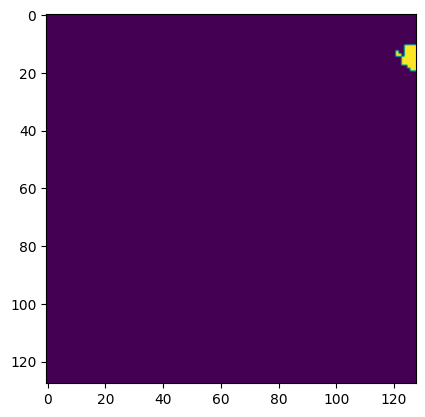

0.0
0.9939393939393939


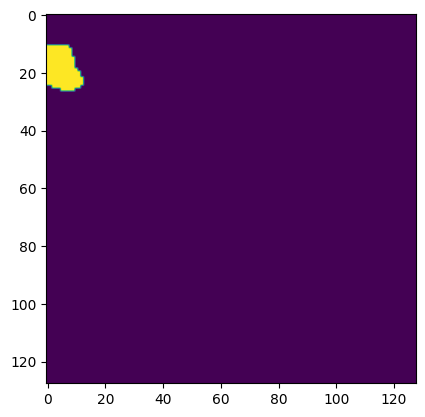

0.8571428571428572


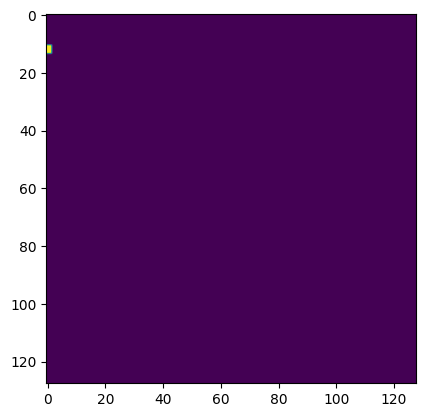

0.9956709956709957


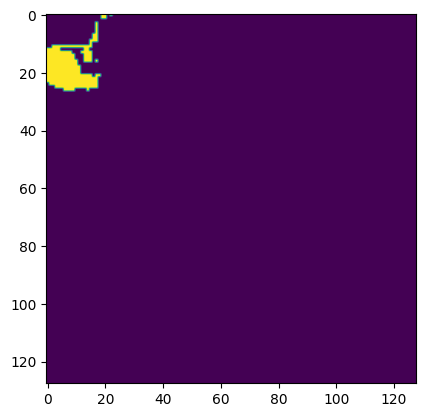

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.9787234042553191


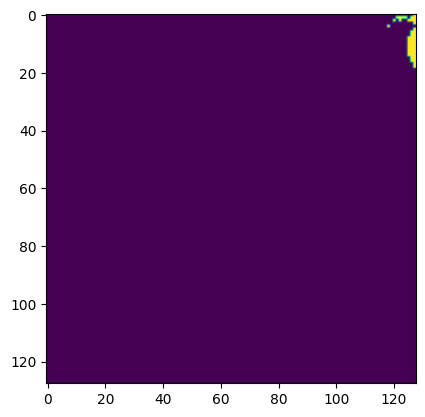

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.9


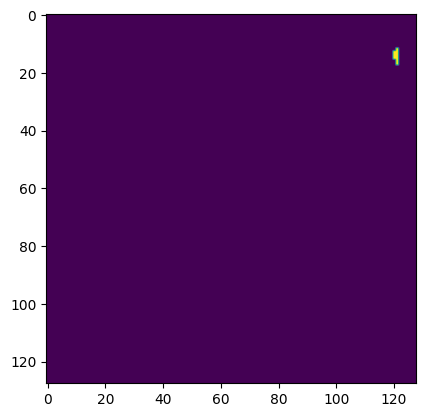

0.0
0.0
0.9957983193277311


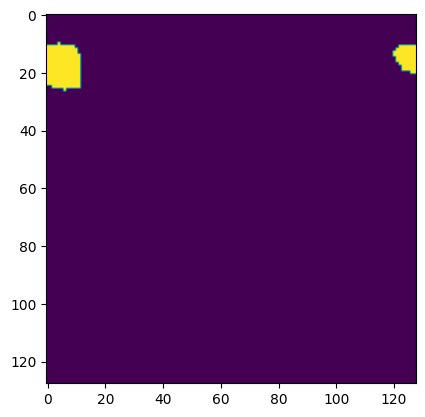

0.8571428571428572


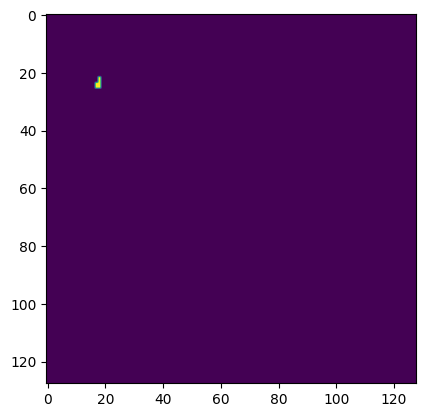

In [291]:
#my msitake may have come from giving the perfect model trained on cellpose model predictions the none cellpose predictions

for i in range(len(X_test_split_cellprobs)):
    if len(np.unique(y_test_split[i])) == 2:
        continue
    input = torch.from_numpy(X_test_split_cellprobs[i]).float()
    input = torch.unsqueeze(torch.unsqueeze(input,0),0)
    input = input.to('cuda:0')

    pred = cellmask_cellpose(input)[1].cpu().detach().numpy()

    pred = F.sigmoid(torch.from_numpy(pred))
    pred = np.where(pred > 0.5, 1, 0)
    print(get_dice_coeff(pred, y_test_split[i]))
    if len(np.unique(pred)) != 1:
        plt.imshow(pred[0,0,:,:])
        plt.show()

In [224]:
def get_dice_coeff(pred, target):
    pred = pred.flatten()
    target = target.flatten()
    intersection = (pred * target).sum()
    dice_coeff = 1 - (2.*intersection + 1)/(pred.sum() + target.sum() + 1)
    return dice_coeff

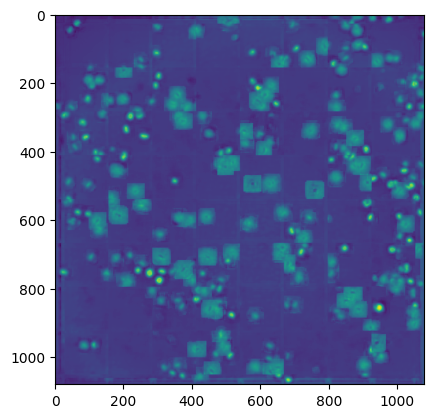

In [318]:
plt.imshow(X_train[0])

c:\Users\rz200\AppData\Local\anaconda3\envs\cellprob\lib\site-packages\torch\nn\functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


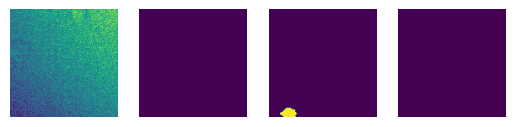

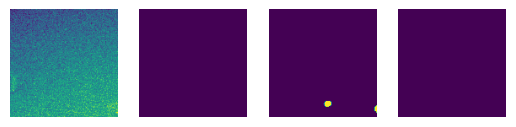

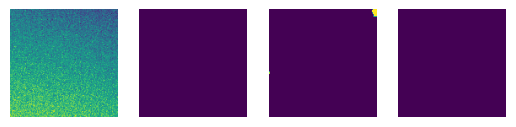

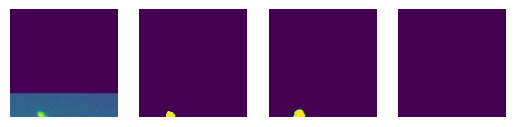

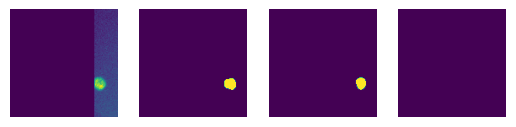

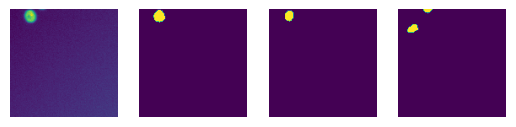

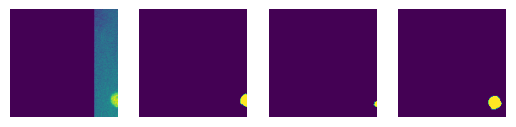

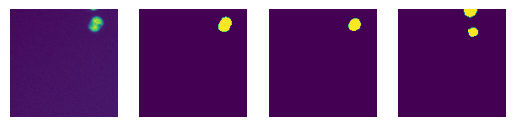

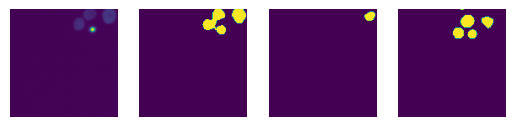

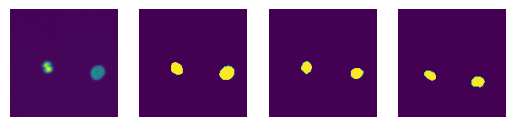

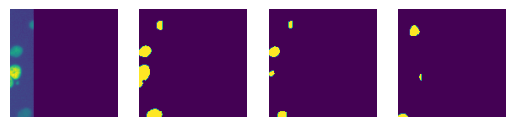

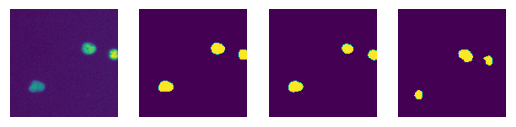

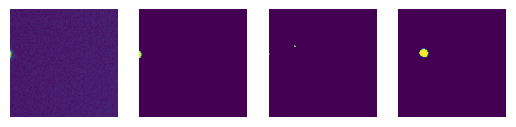

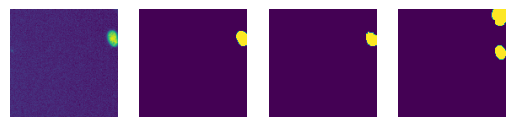

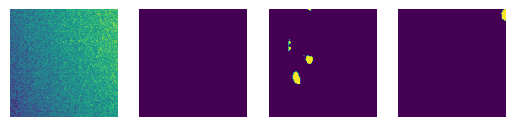

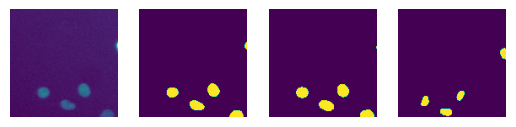

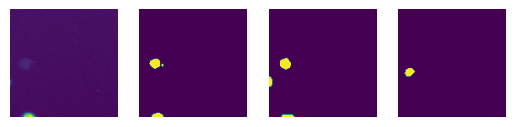

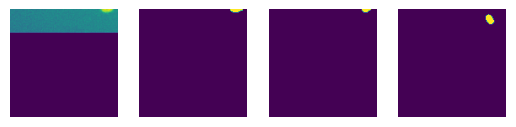

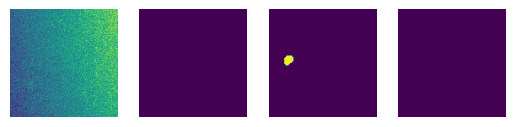

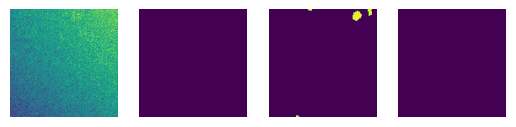

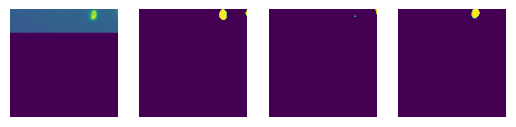

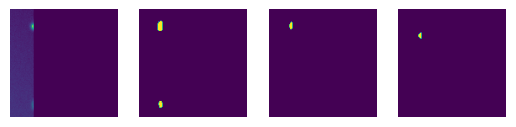

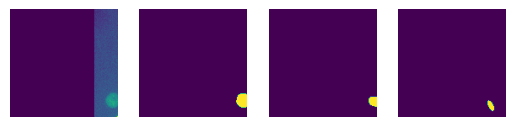

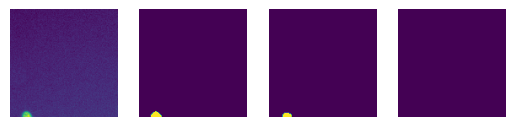

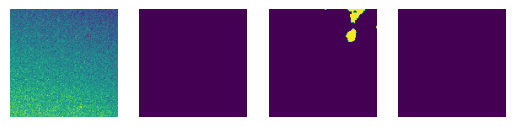

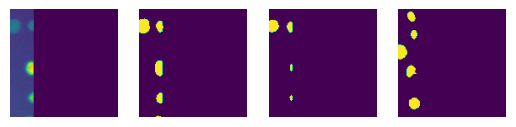

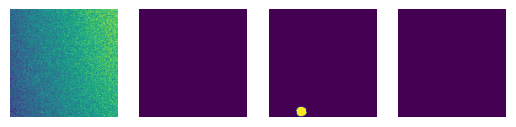

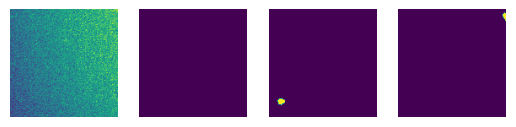

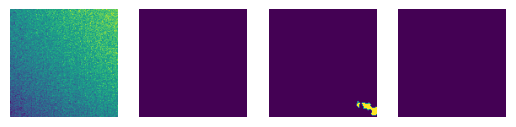

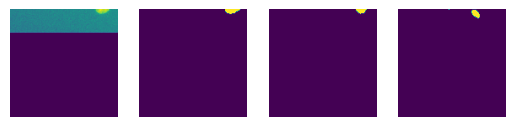

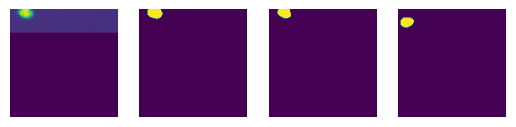

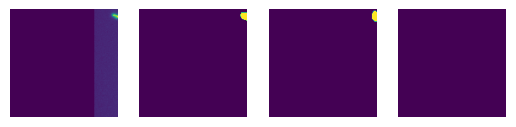

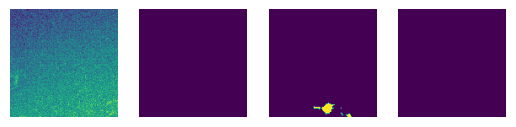

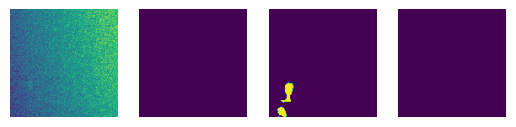

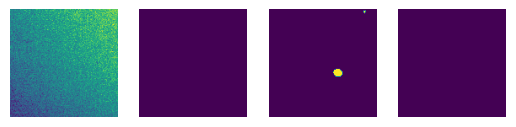

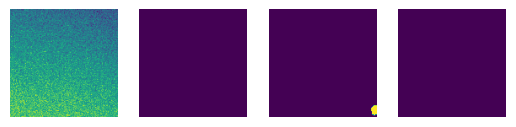

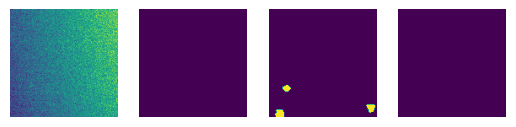

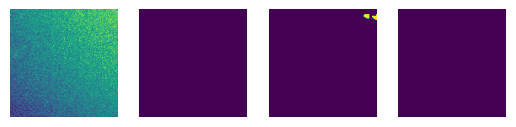

In [321]:
#Then we make it make predictions on the test data and we return the full images

#TODO: add the predictions from our best model that was trained on cellprose predictions
#TODO: add the dice losses under each plots, then we'll be able to sort by worst/best dice losses to find the best and worst predictions
#TODO: get the original cell images to display on the first column

#reshape the test data
#make predictions on the test data and plot them next to the ground truth
cellmask_model.eval()
all_preds_cm = []
for i in range(1000):
    #if len(np.unique(y_test_split[i])) == 1:
    #    continue

    gt_mask = y_train_split[i]

    #Seg model trained on U-Net probability preds
    pred = cellmask_model(torch.unsqueeze(torch.unsqueeze(torch.from_numpy(X_train_split[i].astype('float16')),0),0).float().cuda())
    pred = F.sigmoid(pred[1])
    #binarise the prediction
    pred[pred > 0.5] = 1
    pred[pred <= 0.5] = 0
    pred_cm = pred.cpu().detach().numpy()[0,0,:,:]
    all_preds_cm.append(pred_cm)
    dice_coeff_cm = get_dice_coeff(pred_cm, gt_mask)
    #round dice_coeff to 3 decimal places
    dice_coeff_cm = round(dice_coeff_cm, 3)
    #set as titile of the sub plot the dice coefficient
    
    #Seg model trained on Cellpose probabilities
    pred = cellpose_cellprob_model(torch.unsqueeze(torch.unsqueeze(torch.from_numpy(X_train_split_cellprobs[i].astype('float16')),0),0).float().cuda())
    pred = F.sigmoid(pred[1])
    #binarise the prediction
    pred[pred > 0.5] = 1
    pred[pred <= 0.5] = 0
    pred_ccm = pred.cpu().detach().numpy()[0,0,:,:]
    dice_coeff_ccm = get_dice_coeff(pred_ccm, gt_mask)
    #round dice_coeff to 3 decimal places
    dice_coeff_ccm = round(dice_coeff_ccm, 3)

    if dice_coeff_ccm < 0.98 or len(np.unique(pred_ccm)) == 1:
        continue

    plt.subplot(1,4,1)
    plt.axis('off')
    plt.imshow(images_train_split[i])

    plt.subplot(1,4,2)
    plt.axis('off')
    plt.imshow(pred_cm)

    plt.subplot(1,4,3)
    plt.axis('off')
    plt.imshow(pred_ccm)

    plt.subplot(1,4,4)
    plt.axis('off')
    plt.imshow(gt_mask)
    plt.show()

100


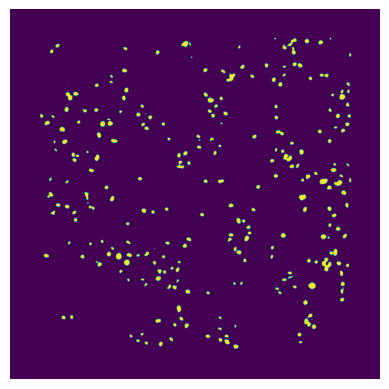

In [331]:
all_crops = all_preds_cm[:100]
print(len(all_crops))
row_images = []
for i in range(0, 100, 10):
    row_image = np.concatenate(all_crops[i:i+10], axis=1)
    row_images.append(row_image)

# Concatenate the row images along the rows to form the final image
final_image = np.concatenate(row_images, axis=0)

# Plot the final image using matplotlib
plt.imshow(final_image)
plt.axis('off')
plt.show()